# 04-linear-&-logistic-regression

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


from ucimlrepo import fetch_ucirepo 

___ 
## 1. Business Understanding

Goal:
1. Linear Regression Model:
    - Construct a linear regression model for predicting house prices, with the ``"Y house price of unit area"`` as the continuous target in the dataset.
2. Logistic Regression Model:
    - Convert the target variable into a binary-valued label based on whether the price is above or below the training set mean, then train a logistic regression classifier to predict that label.


___ 
## 2. Data Understanding

In [24]:
# fetch the dataset 
real_estate_valuation = fetch_ucirepo(id=477) 

df = real_estate_valuation.data.original
df = df.drop(columns="No")

# basic info
df.shape
df.columns
df.isna().sum()

X1 transaction date                       0
X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
X5 latitude                               0
X6 longitude                              0
Y house price of unit area                0
dtype: int64

In [29]:
# target stats
target = "Y house price of unit area"
print("Target statistics:")
print(df[target].describe())
print("Targets median: ", df[target].median())
print("Target max-min: ", df[target].max() - df[target].min())

Target statistics:
count    414.000000
mean      37.980193
std       13.606488
min        7.600000
25%       27.700000
50%       38.450000
75%       46.600000
max      117.500000
Name: Y house price of unit area, dtype: float64
Targets median:  38.45
Target max-min:  109.9


Plotting the data for visualization. 
- X-axel: Each of the columns, except the target ("Y house price of unit area")
- Y-axel: ("Y house price of unit area")

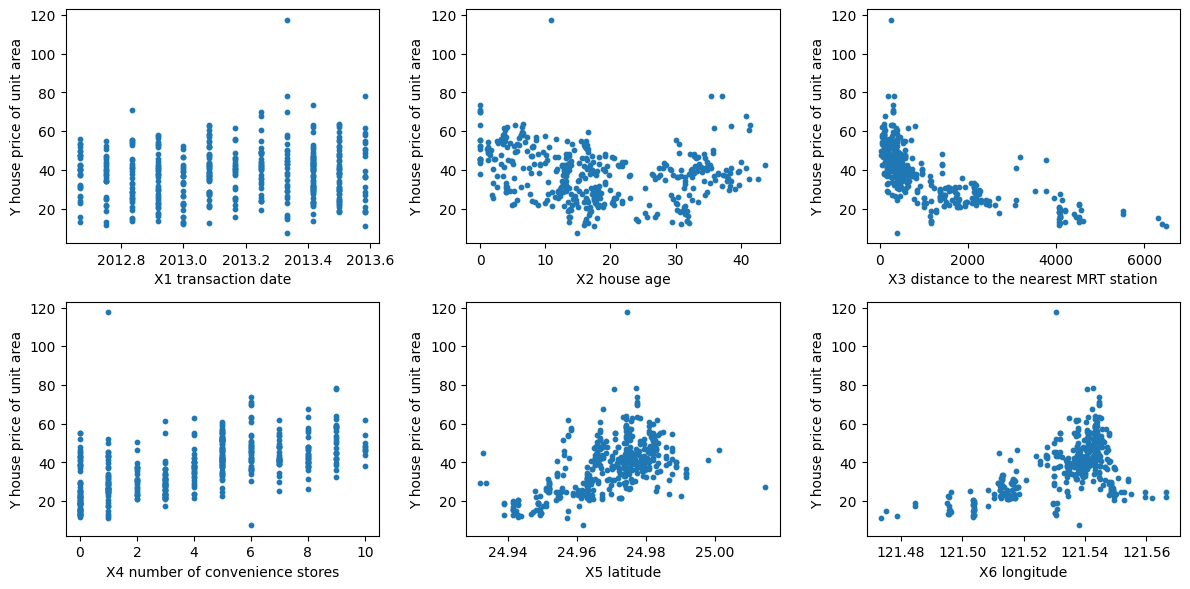

In [35]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
ax = ax.ravel()

# For each column except the target.
for i in range(6):
    X = df.iloc[:, i] 
    y = df[target]
    ax[i].scatter(df.iloc[:, i], y, s=10)
    ax[i].set_ylabel(df.columns[6])
    ax[i].set_xlabel(df.columns[i])

plt.tight_layout()
plt.show()

___ 
## 3. Data Preparation


Preparation of the data:
- Defining features and target.
- Train and test data splitting.

In [37]:
# 1) features and target
target = "Y house price of unit area"
X = df.drop(columns=[target])
y = df[target]

# 2) train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# 3) standardized features (fit on train only)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

___ 
## 4.1 Modeling (Linear Regression)

In [ ]:
# Train linear regression on standardized features
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict and evaluate
preds = model.predict(X_test_scaled)

___ 
## 4.2 Modeling (Logistic Regression)

___ 
## 5. Evaluation



___ 
## 6. Deployment

